In [ ]:
%pip install langgraph

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### **StateGraph로 상태 만들기**
- StateGraph란 노드와 노드사이에 정보를 주고받을때 우리가 정해준 특정한 state라는 틀안에서 정보를 주고 받을 수 있도록 만들어주는 그래프.

In [5]:
from typing import TypedDict
from langgraph.graph import StateGraph

# StateGraph를 만드려면 어떤 상태를 저장해줘야하는 틀을 먼저 만들어줘야한다.
class State(TypedDict): # TypedDict는 타입을 지정해서 딕셔너리 형태로 저장하고. 특성을 지정해준다.
    counter: int # 첫번째 특성으론 counter가 있다. counter는 어떤 노드가 실행될때마다 counter안에 숫자를 넣어주도록 만들것이다 라고 선언
    alphabet: list[str] # 두번째는 alphabet안에 리스트안에 string이 들어갈것이다 라고 선언. (State를 저장할때 주어진 특정 string을 리스트 형태로 저장)
# 정보를 주고 받을 때, 두개의 특성(counter, alphabet)이 계속해서 전달이 된다.


# StateGraph는 우리가 정의한 틀 대로 노드와 노드사이에 정보를 주고 받는다.
graph_builder = StateGraph(State)

# 이런식으로 어떤 틀을 만들고 그래프 안에 해당 틀을 주고 받게끔 만들어줘보았다.
# 실제로 이게 돌아가도록 그래프를 만들어보자 ⬇️

In [1]:
from typing import Annotated
from typing_extensions import TypedDict # typing에서 가져오든 typing_extensions에서 가져오든 상관없긴함. (공식문서에선 typing_extensions에서 가져오도록 돼있음)

from langgraph.graph import StateGraph, START, END
import operator

# state를 만들고
class State(TypedDict):
    counter: int
    alphabet: list[str]

# 노드는 함수 형태로 만들어주면 된다. 어떤 함수든 상관없고, 대신에 입력값으로 우리가 class로 정해준 State를 제공받아야 한다.
def node_a(state: State): # state라는 입력값을 받을건데 그 state는 위에서 선언한 class State로 선언. (node_a는 class State틀 안에있는 입력값을 가져오겠다 라는 의미)
    state['counter'] += 1 # state값 안에있는 counter에 1씩 더하고
    state['alphabet']= ["Hello"] # state값 안에 있는 alphabet에는 Hello라는 리스트를 지정하곘다. (함수 매개변수로 state: State를 지정해줬기 때문에 State안에 있는 값들을 이용할 수가 있다.)
    return state # state값들을 업데이트 해준뒤 반환한다.

# StateGraph를 만들어준다.
graph_builder = StateGraph(State)

# 어떤 점이 있는지 알려줘야 점과 점사이를 연결해준다.
# 첫번째 노드로 chatbot이라는 이름의 만들어준다. 그리고 이 노드를 거칠때는 node_a를 실행한다. 라는 의미 (노드 한개를 갖는 그래프가 완성됨)
graph_builder.add_node("chatbot", node_a)

# 그리고 어떤 방향으로 갈지 엣지를 넣어 줘야함. 이 노드는 함수를 실행한 뒤에 어떤 행동을 해야되는지에 대해서 우리가 엣지로 방향성을 만들어줘야한다.
graph_builder.add_edge(START, "chatbot") # 시작을 하면 chatbot으로 가고
graph_builder.add_edge("chatbot", END) # chatbot에서는 END로 간다고 그래프를 만듬

graph = graph_builder.compile() # 이 그래프를 실행 가능한 객체로 만들어주기 위해선 compile함수를 실행해주면된다.

# 이 그래프가 잘 완성이 되었는지 시각화를 해보자 

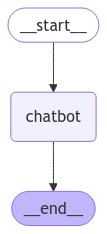

In [2]:
# 랭그래프는 주피터내에서 그래프를 시각화 해줄 수 있게 명령문을 제공하고있다.

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# 초기 상태 정의
initial_state = {
    "counter": 0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')


In [4]:
class State(TypedDict):
    counter: int
    alphabet: Annotated[list[str], operator.add] # Annotated

def node_a(state: State):
    state['counter'] += 1
    state['alphabet']= ["Hello"]
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [6]:
# 초기 상태 정의
initial_state = {
    "counter": 0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

# 결과를 보면 alphabet키의 리스트가 계속 늘어나는걸 볼 수 있다.
# 그 이유는 Annotated를 통해서 operator.add를 수행한 결과이다. (alphabet: Annotated[list[str], operator.add])
# list[str]을 우리가 주어진 입력값으로 넣을건데 operator.add에 의해서 list[str]값이 계속 해서 새로운 str으로 업데이트 되는게 아닌, 기존의 str을 남겨 놓은 상태에서 새로운 str을 계속 더해나간다.
# 이게 중요한 이유는 우리가 챗봇을 만들 때, 이전에 어떤 대화를 했었는지에 대해서 이 그래프내에서 기억을 저장해주기 위해선 나와 AI가 나눴던 대화내역들을
# 계속해서 list[str]형태로 저장할 필요가 있다.
# 그래서 Annotated로 만들어주는 이 부분 => alphabet: Annotated[list[str], operator.add] 은 챗봇의 기억을 만들어준다. 라고 보면된다.
# 💡 하지만 이 기억은 그래프 내에서만 지속이 되는 기억이라는 점.
# 💡 만약에 내가 그래프를 한번 실행하고 나서 똑같은 그래프를 또 한번 실행하게 되면 이 기억이 전부 초기화되게 된다.
# 나중에 어떻게하면 그래프와 그래프 사이에서의 기억력을 지속 시킬수 있는지도 알아보자.

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


### **Message를 담는 StateGraph 만들기**
- Message를 담는 StateGraph라고 이름을 칭한 이유는
- 이번에 LLM이 보내준 답변과 우리가 보낸 답변. 이런 것들을 state에 담아서 만들어주기 위해서다.
- 대화내역이 저장되게끔 이전에 사용한 operator.add 대신 랭그래프의 모듈 add_messages을 사용해보자

In [7]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages] # 메세지를 list형태로 계속 누적해서 쌓는다.


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")

# 이 chatbot은 State를 입력받는데, State에 messages에 있는 list값을 그대로 LLM에게 넘겨줘서 그것의 답변 결과를 messages로 다시 업데이트 해서 반환하겠다. 라는 의미
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]} # 즉, 계속해서 우리가 나눴던 대화내역들을 chatbot에 보내주겠다.

graph_builder.add_node("chatbot", chatbot) # 노드로 등록
graph_builder.set_entry_point("chatbot") # 시작점이 chatbot이란 뜻. 시작점(START)과 노드, 노드와 끝점(END)을 연결해주걸 똑같이 수행해주는 함수. 위에 했던 add_edge(START, "chatbot")랑 똑같음
graph_builder.set_finish_point("chatbot") # chatbot에서 그래프가 끝
graph = graph_builder.compile()

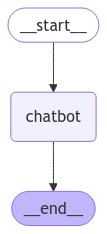

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]: # "quit", "exit", "q" 챗봇 종료
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}): # 사용자가 input 넣은것을 처음에 초기값으로 설정. 
        for value in event.values(): # inpurt 들어간 값을 기반으로해서 messages가 업데이트 되고
            print("Assistant:", value["messages"][-1].content) # messages가 업데이트 된것중에 가장 최신의 content를 가져와서 Assistant로 선언

Assistant: 안녕하세요! 어떻게 도와드릴까요?
Assistant: 안녕하세요, 밥님! 어떻게 도와드릴까요?
Assistant: 죄송하지만, 당신의 이름을 알 수 있는 정보가 없습니다. 이름을 알려주시면 그에 대해 이야기할 수 있습니다!
Assistant: 죄송하지만, 당신의 이름을 알 수 있는 방법이 없습니다. 필요하신 정보나 질문이 있다면 도와드릴 수 있습니다!
Assistant: 안녕하세요, 밥님! 어떻게 도와드릴까요?
Assistant: 죄송하지만, 당신의 이름을 알 수 있는 방법이 없습니다. 당신의 이름을 직접 말씀해 주시면 그에 대해 이야기할 수 있습니다!
Goodbye!


In [165]:
# MessagesState에 대해서 알아보자
# 위에 Annotated[list, add_messages]이런 정의를 안해도 래핑이 돼있는 라이브러리.
# 위 처럼 class State를 지정해주지 않아도 다 래핑 돼있는 라이브러리
# 간단한 일반 챗봇을 만들고 싶을때 해당 라이브러리 사용 (자주 쓰이지 않을것임. 굉장히 단순한 형태의 챗봇에서만 사용됨)
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState) #  MessagesState 사용

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [167]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  안녕


Assistant: 안녕하세요! 어떻게 도와드릴까요?


User:  너는 이름이 뭐야


Assistant: 저는 AI 언어 모델이어서 이름은 없지만, 필요하신 정보나 도움이 필요하시면 언제든지 말씀해 주세요!


User:  q


Goodbye!


In [11]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

class State(MessagesState):
    counter: int
    
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    state['counter'] = state.get('counter', 0) + 1
    return {
        "messages": [llm.invoke(state["messages"])],
        "counter":state['counter']
           }

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [12]:
from langchain_core.messages import HumanMessage

# 초기 상태 설정
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "counter": 0
}

# 그래프 실행
result = graph.invoke(initial_state)

print(f"Final state: {result}")

Final state: {'messages': [HumanMessage(content='Hello!', id='1562784d-4cca-4a30-8373-a134d96d73d4'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-d450a230-64fb-4f70-846d-fb74651a1c43-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})], 'counter': 1}


In [173]:
state = initial_state
for _ in range(3):
    state = graph.invoke(state)
    print(f"Counter: {state['counter']}")
    print(f"Last message: {state['messages'][-1].content}")
    print("---")

# initial_state(초기값)에 메세지를 똑같이 넣고 진행했기 때문에 답변이 똑같이 나오는걸 볼 수 있다.

Counter: 1
Last message: Hello! How can I assist you today?
---
Counter: 2
Last message: Hello! How can I assist you today?
---
Counter: 3
Last message: Hello! How can I assist you today?
---


##### 지금까지 기본적인 그래프로 챗봇을 구축 해보았다.
처음에 State를 선언하고 그래프에 State를 넣어주고 </br>
node는 그 State에 있는 특성들을 이용하는 방식이 익숙하지 않을 수 있다. </br>
node는 그냥 함수고 State는 이 함수가 주고 받을 입출력 값에 해당하는 특성을 정해주는 것이다. 라고 이해하면 된다. </br>
계속 보다보면 단순하다. </br>